# DTW-SOM Evaluation - experiment with the UWaveGesture dataset

## 1. Packadge import

In [1]:
import os
import csv
import math
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pyclustering.nnet.som import type_conn
from matrixprofile import matrixProfile, motifs
# local code
import sys
sys.path.insert(0, os.path.abspath('../src'))
import dtwsom

## 2. Preprare the UWaveGesture dataset

Load the dataset:

In [2]:
ucr_data_folder = os.path.abspath("../../data-ucr-archive")
file = os.path.join(ucr_data_folder, "UWaveGestureLibraryX", "UWaveGestureLibraryX_TRAIN.tsv")
ts_data = []
ts_labels = []
with open(file) as tsvfile:
    tsvreader = csv.reader(tsvfile, delimiter="\t", quoting=csv.QUOTE_NONNUMERIC)
    for line in tsvreader:
        ts_labels.append(line[0])
        ts_data.append(np.array(line[1:]))
size = len(ts_data[0])
classes = len(set(ts_labels))
print("Subquence size: "+str(size))
print("No of classes: "+str(classes))
print("Dataset size:: "+str(len(ts_labels)))

Subquence size: 315
No of classes: 8
Dataset size:: 896


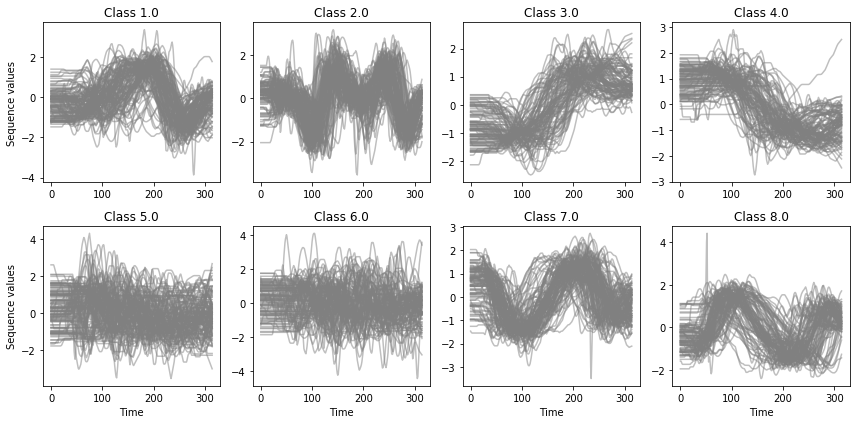

In [3]:
fig, axs = plt.subplots(2, 4, figsize=(12,6))
for i in range(len(ts_labels)):
    label = ts_labels[i]-1
    col = int(label % 4)
    row = math.floor(label/4)
    axs[row, col].plot(np.arange(size), ts_data[i], alpha=0.5, color="grey")
    axs[row, col].set_title("Class "+str(label+1))
    if col==0:
        axs[row, col].set_ylabel("Sequence values")
    if row==1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

Now, let's exclude classes 5 and 6 and sample the rest of the dataset so that the run is quicker:

In [4]:
filter_ts_labels = []
filter_ts_data = []
for i in range(len(ts_labels)):
    if ts_labels[i] not in [5.0, 6.0]:
        filter_ts_data.append(ts_data[i])
        filter_ts_labels.append(ts_labels[i])
print(set(filter_ts_labels))
print(len(filter_ts_labels))

{1.0, 2.0, 3.0, 4.0, 7.0, 8.0}
658


In [5]:
sample_indexes = random.sample(range(len(filter_ts_data)), 400)
ts_data = [filter_ts_data[i] for i in sample_indexes]
ts_labels = [filter_ts_labels[i] for i in sample_indexes]

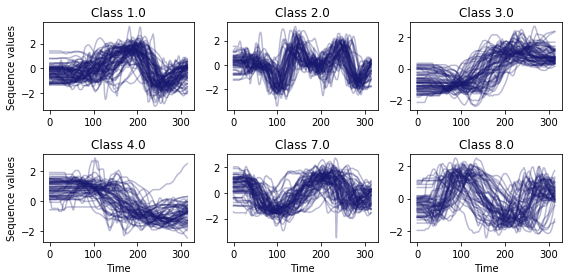

In [41]:
fig, axs = plt.subplots(2, 3, figsize=(8,4))
for i in range(len(ts_labels)):
    label = ts_labels[i]-1
    if label > 3:
        col = int((label-2) % 3)
        row = math.floor((label-2)/3)
    else:
        col = int(label % 3)
        row = math.floor(label/3)
    axs[row, col].plot(np.arange(size), ts_data[i], alpha=0.3, color="midnightblue")#darkorange
    axs[row, col].set_title("Class "+str(ts_labels[i]))
    if col==0:
        axs[row, col].set_ylabel("Sequence values")
    if row==1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

Convert it to a single time-series by concatenating each subsequence:

In [7]:
joined_ts_data = ts_data[0]
joined_ts_labels = [ts_labels[0]]*size
for i in range(1, len(ts_labels)):
    joined_ts_data = np.concatenate((joined_ts_data, ts_data[i]))
    joined_ts_labels = joined_ts_labels + [ts_labels[i]]*size
len(joined_ts_data)

126000

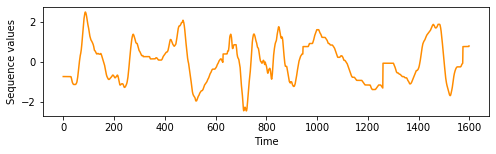

In [43]:
plt.figure(figsize=(8,2))
plt.plot(np.arange(1600), joined_ts_data[:1600], color="darkorange")
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

Compute the matrix profile with STOMP:

In [9]:
%%time
mp = matrixProfile.stomp(joined_ts_data, size)

CPU times: user 6min 47s, sys: 2.08 s, total: 6min 49s
Wall time: 6min 50s


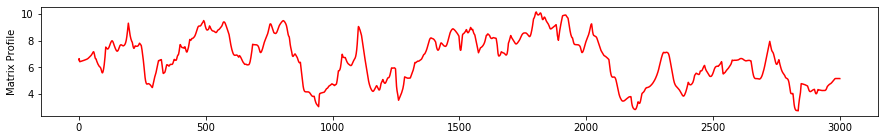

In [10]:
mp_adj = np.append(mp[0],np.zeros(size-1)+np.nan)

plt.figure(figsize=(15,2))
plt.plot(np.arange(3000), mp_adj[:3000], color='red')
plt.ylabel("Matrix Profile")
plt.show()

Extract all the motifs:

In [11]:
%%time
mtfs, motif_d  = motifs.motifs(joined_ts_data, mp, max_motifs=1000)
len(mtfs)

CPU times: user 2.12 s, sys: 9.45 ms, total: 2.13 s
Wall time: 2.13 s


125

Create list of motifs centers:

In [12]:
motif_center_list = []
motif_center_labels = []
for motif in mtfs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center_ts = joined_ts_data[center_pointers]
    motif_center_list.append(motif_center_ts)
    center_labels = [joined_ts_labels[i] for i in center_pointers]
    center_final_label = max(center_labels, key=center_labels.count)
    motif_center_labels.append(center_final_label)

## 3. Train DTW-SOM with random initialization and view results

Define the SOM network:

In [13]:
%time
n = 4
rows = n
cols = n
structure = type_conn.grid_four
dtw_params = dtwsom.DtwParameters(window=100)
network = dtwsom.DtwSom(rows, cols, structure, dtw_params=dtw_params)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


Train the network:

In [14]:
%%time
network.train(motif_center_list, 20)

Epoch 1 achieved an average quantization error of 5.7974
Epoch 2 achieved an average quantization error of 6.0197
Epoch 3 achieved an average quantization error of 6.2789
Epoch 4 achieved an average quantization error of 6.3428
Epoch 5 achieved an average quantization error of 6.2364
Epoch 6 achieved an average quantization error of 6.2587
Epoch 7 achieved an average quantization error of 6.1879
Epoch 8 achieved an average quantization error of 6.1533
Epoch 9 achieved an average quantization error of 6.08
Epoch 10 achieved an average quantization error of 6.0714
Epoch 11 achieved an average quantization error of 6.064
Epoch 12 achieved an average quantization error of 6.0918
Epoch 13 achieved an average quantization error of 6.1073
Epoch 14 achieved an average quantization error of 5.8533
Epoch 15 achieved an average quantization error of 5.6764
Epoch 16 achieved an average quantization error of 5.5444
Epoch 17 achieved an average quantization error of 5.4289
Epoch 18 achieved an avera

20

Vizualise DTW-SOM U-matrix:

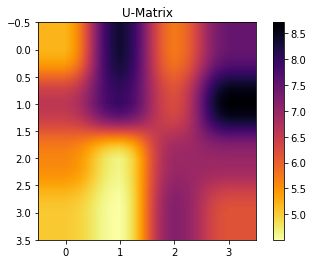

In [15]:
network.show_distance_matrix()

Vizualise the winner matrix:

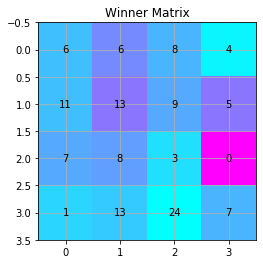

In [16]:
network.show_winner_matrix()

Vizualise the units' sequence values:

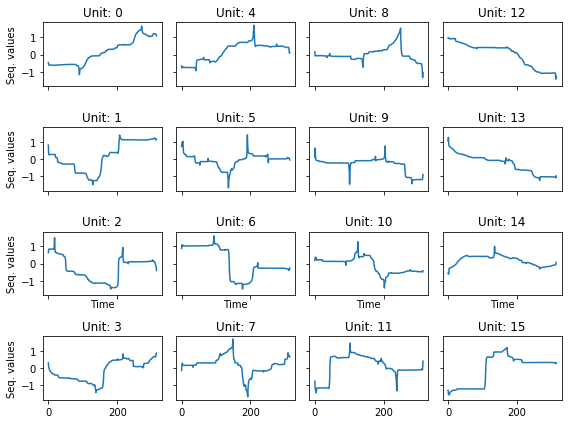

In [46]:
n_neurons = network._size
fig, axs = plt.subplots(n,n,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/n)
    row = neuron_index % n
    neuron_weights = network._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Seq. values")
    if row == 2:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

## 4. Explore clusters

In [18]:
true_labels = []
predicted_labels = []
for cluster_list in network.capture_objects:
    if len(cluster_list)>0:
        cluster_true_labels = [motif_center_labels[i] for i in cluster_list]
        cluster_label = max(cluster_true_labels, key=cluster_true_labels.count)
        cluster_predicted_labels = [cluster_label]*len(cluster_true_labels)
        true_labels += cluster_true_labels
        predicted_labels += cluster_predicted_labels
accuracy = np.mean([i==j for i,j in zip(true_labels, predicted_labels)])
accuracy

0.512

In [19]:
cluster_label_dict = {}
for i, cluster_list in enumerate(network.capture_objects):
    if len(cluster_list)>0:
        cluster_true_labels = [motif_center_labels[i] for i in cluster_list]
        cluster_label = max(cluster_true_labels, key=cluster_true_labels.count)
        cluster_label_dict[i] = cluster_label
cluster_label_dict

{0: 3.0,
 1: 7.0,
 2: 1.0,
 3: 1.0,
 4: 3.0,
 5: 2.0,
 6: 3.0,
 7: 1.0,
 8: 4.0,
 9: 7.0,
 10: 4.0,
 11: 1.0,
 12: 4.0,
 13: 4.0,
 15: 3.0}

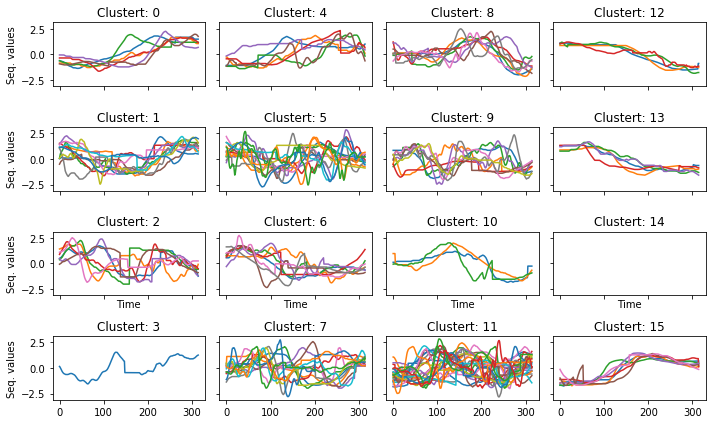

In [48]:
n_neurons = network._size
fig, axs = plt.subplots(n,n,figsize=(10, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/n)
    row = neuron_index % n
    cluster_list = network.capture_objects[neuron_index]
    for member_index in cluster_list:
        axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
    axs[row, col].set_title("Clustert: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Seq. values")
    if row == 2:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

#### Cluster 5:

In [21]:
len(network.capture_objects[5])

13

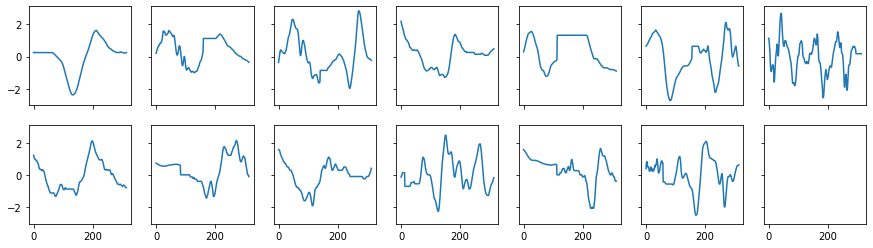

In [24]:
fig, axs = plt.subplots(2,7,figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network.capture_objects[5]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

#### Cluster 6:

In [30]:
len(network.capture_objects[6])

8

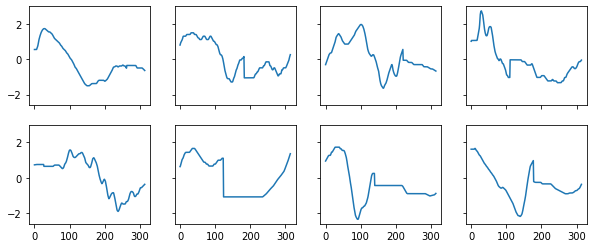

In [31]:
fig, axs = plt.subplots(2,4,figsize=(10, 4), sharex=True, sharey=True)
cluster_list = network.capture_objects[6]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

#### Cluster 7:

In [25]:
len(network.capture_objects[7])

13

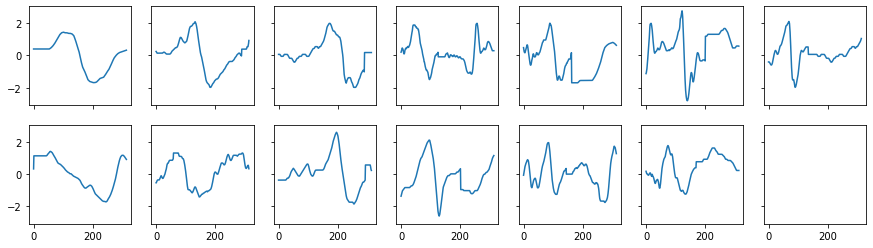

In [27]:
fig, axs = plt.subplots(2,7,figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network.capture_objects[7]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

#### Cluster 11:

In [28]:
len(network.capture_objects[11])

24

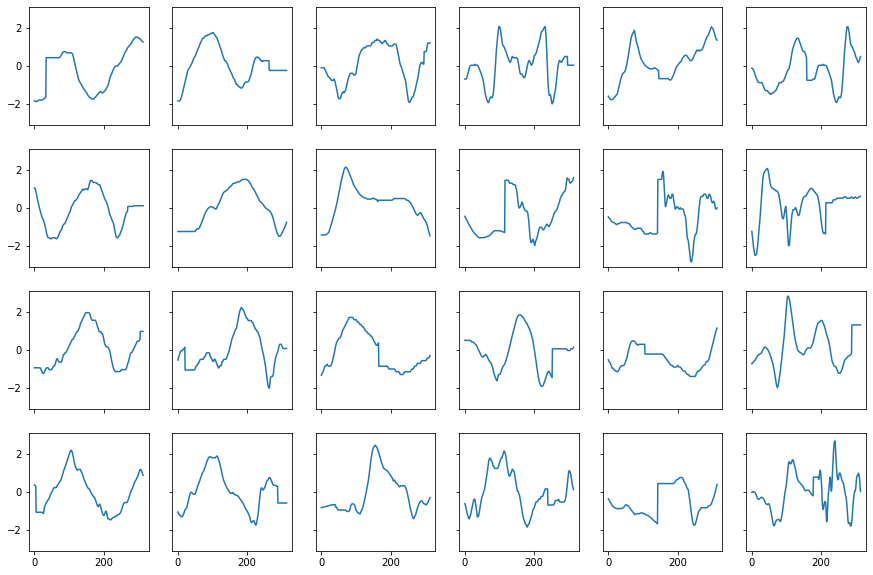

In [29]:
fig, axs = plt.subplots(4,6,figsize=(15, 10), sharex=True, sharey=True)
cluster_list = network.capture_objects[11]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/4)
    row = i % 4
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

#### Cluster 15:

In [33]:
len(network.capture_objects[15])

7

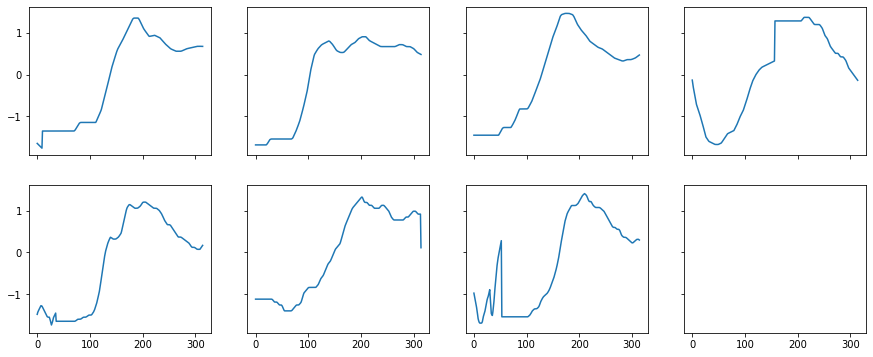

In [34]:
fig, axs = plt.subplots(2,4,figsize=(15, 6), sharex=True, sharey=True)
cluster_list = network.capture_objects[15]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

## 5. Checkpoint results

In [49]:
pickle.dump(joined_ts_data, open("joined_ts_data.p", "wb"))
pickle.dump(motif_center_list, open("motif_center_list.p", "wb"))
pickle.dump(motif_center_labels, open("motif_center_labels.p", "wb"))
pickle.dump(mtfs, open("mtfs.p", "wb"))
pickle.dump(network, open("network.p", "wb"))